In [2]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [3]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [4]:
# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.
NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.050 s)


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [6]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [7]:
def plot_histogram(df, name):
    # Most common unit
    unit = df.groupby('unit').nunique().value.sort_values(ascending=False).index[0]
    avg = df.value.mean()
    stdev = df.value.std()

    fig, ax = plt.subplots()
    df.hist('value', bins=20, label=f'Total: {df.shape[0]:,}', ax=ax)
    ax.legend()
    ax.set(xlabel=f'{name} ({unit})', ylabel='count',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    plt.savefig(f'notebooks/hist.{name.replace(" ", "_")}.png', dpi=300)
    plt.show()

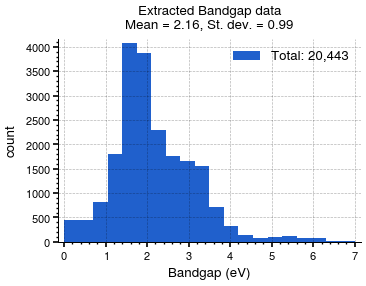

In [8]:
df0 = execute("""
    SELECT * FROM extracted_data
    WHERE property = 'bandgap'
    -- AND confidence = 1  -- polymer only
""")
plot_histogram(df0, 'Bandgap')
# df.sort_values('value')

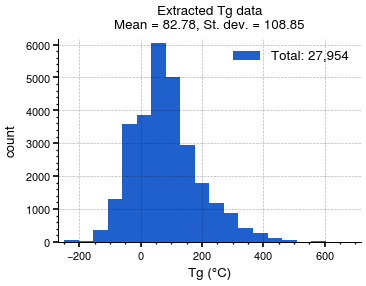

In [9]:
df1 = execute("""
    SELECT * FROM extracted_data
    WHERE property = 'tg'
    -- AND confidence = 1  -- polymer only
""")
plot_histogram(df1, 'Tg')
# df.sort_values('value')


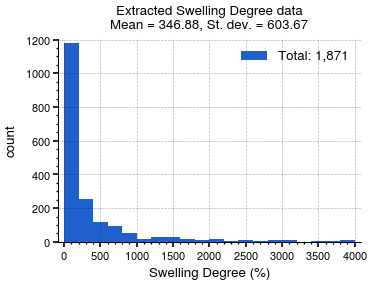

In [10]:
df2 = execute("""
    SELECT * FROM extracted_data
    WHERE property = 'sd'
    -- AND confidence = 1  -- polymer only
""")
plot_histogram(df2, 'Swelling Degree')
# df.sort_values('value')